In [43]:
import numpy as np
import pandas as pd
import os,gc,random
import pickle
from tqdm.notebook import tqdm
from collections import OrderedDict
import h5py
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from transforms import adaptive_resize
from numpy.lib.stride_tricks import sliding_window_view
import seaborn as sns

In [67]:
PATH = 'input/g2net-detecting-continuous-gravitational-waves/test/'
OUT = 'input/g2net-detecting-continuous-gravitational-waves/leak_2.pickle'

df = pd.read_csv('input/test_stationery.csv')
df = df.loc[~df.stationery]
df.head()

,id,stationery,freq
14,004f1b282,False,391.430278
17,006e25113,False,479.295278
23,008ec5560,False,317.477500
24,00948246a,False,227.008611
38,0112d6cc3,False,335.537500


In [45]:
def extract_data_from_hdf5(path):
    data = {}
    # with h5py.File(path, "r") as f:
    #     ID_key = list(f.keys())[0]
    #     # Retrieve the frequency data
    #     data['freq'] = np.array(f[ID_key]['frequency_Hz'])
    #     # Retrieve the Livingston decector data
    #     data['L1_SFTs_amplitudes'] = np.array(f[ID_key]['L1']['SFTs'])
    #     data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])
    #     # Retrieve the Hanford decector data
    #     data['H1_SFTs_amplitudes'] = np.array(f[ID_key]['H1']['SFTs'])
    #     data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
    with open(path, 'rb') as fp:
        f = pickle.load(fp)
        ID_key = list(f.keys())[0]
        # Retrieve the frequency data
        data['freq'] = np.array(f[ID_key]['frequency_Hz'])
        # Retrieve the Livingston decector data
        data['L1_SFTs_amplitudes'] = np.array(f[ID_key]['L1']['SFTs'])
        data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])
        # Retrieve the Hanford decector data
        data['H1_SFTs_amplitudes'] = np.array(f[ID_key]['H1']['SFTs'])
        data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
    return data

def get_correlation(x1,x2):
    correlation = (torch.einsum('ki,kj->ij', x1, x2)/x1.shape[0] - \
                   torch.einsum('i,j->ij', x1.mean(0), x2.mean(0)))/ \
                   torch.einsum('i,j->ij', x1.std(0), x2.std(0))
    return correlation


def load_test_spec(gid):
    fname = Path(f'input/g2net-detecting-continuous-gravitational-waves/test/{gid}.pickle')
    with open(fname, 'rb') as fp:
        f = pickle.load(fp)
        sig_h1, time_h1 = f[gid]['H1']['SFTs']*1e22, np.array(f[gid]['H1']['timestamps_GPS'])
        sig_l1, time_l1 = f[gid]['L1']['SFTs']*1e22, np.array(f[gid]['L1']['timestamps_GPS'])
    spec_h1 = sig_h1.real ** 2 + sig_h1.imag ** 2
    spec_l1 = sig_l1.real ** 2 + sig_l1.imag ** 2
    return spec_h1, spec_l1


def resize_image(img, img_size):
    return adaptive_resize(img[:, :, None], img_size, np.mean)[:, :, 0]

In [69]:
with open(OUT, 'rb') as handle:
    clean_data = pickle.load(handle)

MemoryError: 

In [5]:
# # clean_data = {}
# TH = 0.95
# # for index, row in tqdm(df.iterrows()):
# for index, row in tqdm(df.query('id == "3de0d575a"').iterrows(), total=len(df)):
# # for index, row in tqdm(df.loc[df['id'].isin(target_handlabel.query('target == 1')['id'])].head(5).iterrows()):
# # for index, row in tqdm(df.loc[df['id'].isin(WRONG_LIST)].iterrows()):
#     idx,freq = row[['id','freq']]
#     #print(idx)
#     neigbors = df.loc[np.abs(df.freq.values - freq) < 0.2, ['id','freq']].set_index('id').to_dict()['freq']
#     del neigbors[idx]
#     if len(neigbors) == 0: continue
        
#     # data_src = extract_data_from_hdf5(os.path.join(PATH, idx+'.hdf5')) 
#     data_src = extract_data_from_hdf5(os.path.join(PATH, idx+'.pickle')) 
#     buf = {'H1': torch.zeros(data_src['H1_SFTs_amplitudes'].shape),
#            'L1': torch.zeros(data_src['L1_SFTs_amplitudes'].shape),
#            'H1_mask': torch.zeros(data_src['H1_SFTs_amplitudes'].shape, dtype=torch.uint8),
#            'L1_mask': torch.zeros(data_src['L1_SFTs_amplitudes'].shape, dtype=torch.uint8),
#            'denoise_pair_H': [],
#            'denoise_pair_L': [],
#            'empty' : True,
#            'signal_stat_H': [],
#            'signal_stat_L': []
#           }

#     for key in neigbors.keys():
#         dfreq = round(1800*(freq - neigbors[key]))
#         if 360 - abs(dfreq) < 40: continue
#         f1s,f2s = max(-dfreq,0), min(len(data_src['freq']) - dfreq,len(data_src['freq']))
#         f1t,f2t = max(dfreq,0), min(len(data_src['freq']) + dfreq,len(data_src['freq']))
#         # data_tgt = extract_data_from_hdf5(os.path.join(PATH, key+'.hdf5'))
#         data_tgt = extract_data_from_hdf5(os.path.join(PATH, key+'.pickle'))
        
#         src_H = torch.from_numpy(np.abs(data_src['H1_SFTs_amplitudes']*1e22))
#         tgt_H = torch.from_numpy(np.abs(data_tgt['H1_SFTs_amplitudes']*1e22))
#         correlation_H = get_correlation(src_H[f1s:f2s],tgt_H[f1t:f2t])
#         src_L = torch.from_numpy(np.abs(data_src['L1_SFTs_amplitudes']*1e22))
#         tgt_L = torch.from_numpy(np.abs(data_tgt['L1_SFTs_amplitudes']*1e22))
#         correlation_L = get_correlation(src_L[f1s:f2s],tgt_L[f1t:f2t])
        
#         if correlation_H.max() > TH:
#             values,indices = correlation_H.max(-1)
#             dif_abs = (src_H[f1s:f2s, values > TH] - tgt_H[f1t:f2t,indices[values > TH]]).abs()
#             sample1 = src_H[f1s:f2s, values > TH].mean(1)
#             sample2 = tgt_H[f1t:f2t, indices[values > TH]].mean(1)
#             min_val = torch.min(buf['H1'][f1s:f2s,values > TH], dif_abs)
#             buf['H1'][f1s:f2s,values > TH] = torch.where(buf['H1_mask'][f1s:f2s,values > TH] == 0,
#                 dif_abs, min_val)
#             buf['H1_mask'][f1s:f2s,values > TH] += 1
#             buf['empty'] = False
#             buf['denoise_pair_H'].append(key)
#             buf['signal_stat_H'].append(dif_abs.mean(1).std()/dif_abs.mean().item())
#             # plt.figure(figsize=(10, 5))
#             # plt.subplot(1, 2, 1)
#             # plt.imshow(resize_image(load_test_spec(idx)[1], 360))
#             # plt.title(idx)
#             # plt.subplot(1, 2, 2)
#             # plt.imshow(resize_image(load_test_spec(key)[1], 360))
#             # plt.title(key)
#             # plt.show()
#             diff_raw = sample1 - sample2
#             diff_raw_roll10 = sliding_window_view(diff_raw, 10, axis=0).mean(axis=-1)
#             print(
#                 np.abs(diff_raw_roll10[diff_raw_roll10 < -1e-4]).sum() / 1e-3, 
#                 np.abs(diff_raw_roll10[diff_raw_roll10 > 1e-4]).sum() / 1e-3)
#             # diff_raw_cumsum = np.cumsum(diff_raw_roll10)
#             v = dif_abs[:, 1024:1512]
#             v = (v - v.min())/(v.max() - v.min())
#             plt.imshow(v)
#             plt.show()
#             plt.plot(diff_raw)
#             plt.plot(diff_raw_roll10)
#             # plt.plot(diff_raw_cumsum)
#             plt.title(f'{idx} - {key}')
#             plt.show()
#         if correlation_L.max() > TH:
#             values,indices = correlation_L.max(-1)
#             dif_abs = (src_L[f1s:f2s, values > TH] - tgt_L[f1t:f2t,indices[values > TH]]).abs()
#             min_val = torch.min(buf['L1'][f1s:f2s,values > TH], dif_abs)
#             buf['L1'][f1s:f2s,values > TH] = torch.where(buf['L1_mask'][f1s:f2s,values > TH] == 0,
#                        dif_abs, min_val)
#             buf['L1_mask'][f1s:f2s,values > TH] += 1
#             buf['empty'] = False
#             buf['denoise_pair_L'].append(key)
#             buf['signal_stat_L'].append(dif_abs.mean(1).std()/dif_abs.mean().item())
#         #print(correlation_H.max(),correlation_L.max())
    
#     if not buf['empty']:
#         del buf['empty']
#         # buf['signal'] = buf['H1'].max() > 0.01 or buf['L1'].max() > 0.01
#         buf['signal'] = max(buf['signal_stat_H']) > 0.40 or max(buf['signal_stat_L']) > 0.40
#         buf['signal_stats'] = (buf['H1'].mean(), buf['L1'].mean())
#         print(idx, buf['denoise_pair_H'])
#         freq_mean = buf['H1'].mean(1)
#         freq_mask = buf['H1_mask'].amax(1) > 0

#         clean_data[idx] = buf
#         #if buf['H1'].max() > 0.01: break
#         #if buf['H1_mask'].max() > 1: break

#         # plt.figure(figsize=(16, 12))
#         # plt.subplot(2, 2, 1)
#         # v = buf['H1_mask']
#         # v = (v - v.min())/(v.max() - v.min())
#         # plt.imshow(v[:,:512])
#         # plt.subplot(2, 2, 2)
#         # v = buf['L1_mask']
#         # v = (v - v.min())/(v.max() - v.min())
#         # plt.imshow(v[:,:512])
#         # plt.subplot(2, 2, 3)
#         # v = buf['H1']
#         # v = (v - v.min())/(v.max() - v.min())
#         # plt.imshow(v[:,:512])
#         # plt.subplot(2, 2, 4)
#         # v = buf['L1']
#         # v = (v - v.min())/(v.max() - v.min())
#         # plt.imshow(v[:,:512])
#         # plt.suptitle(f'{buf["signal"]} / {buf["signal_stat_H"]} / {buf["signal_stat_L"]}')
#         # plt.show()
#         plt.savefig(f'input/plot/leak_pos/{idx}.png', facecolor='white')
#         plt.close()
# # with open(OUT, 'wb') as handle:
# #     pickle.dump(clean_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [56]:
leak_target = pd.read_csv('input/denoised_target_2.csv')
# leak_target['coverage'] = leak_target['id'].apply(lambda x: 0.5*(clean_data[x]['coverage_H1']+clean_data[x]['coverage_L1']).item())

In [63]:
leak_target['target']

0      0
1      1
2      0
3      1
4      0
      ..
813    1
814    0
815    0
816    0
817    0
Name: target, Length: 818, dtype: int64

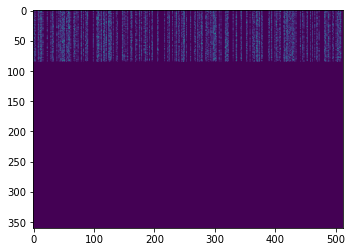

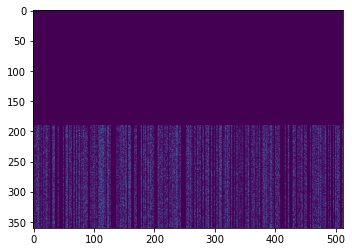

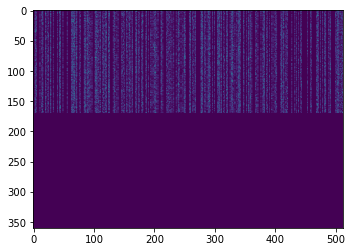

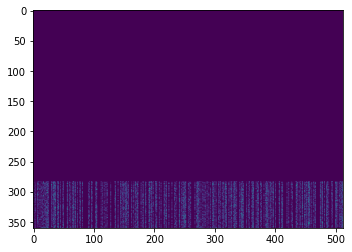

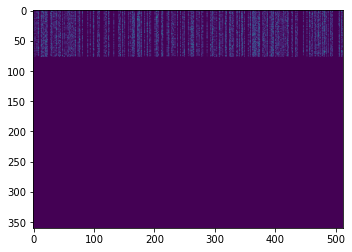

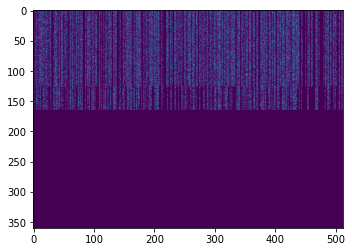

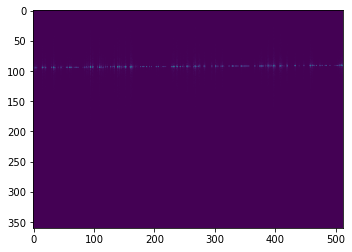

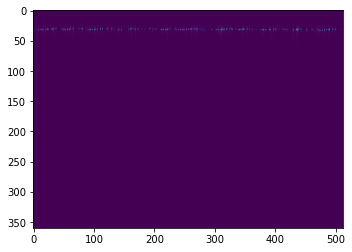

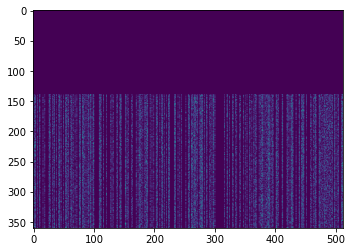

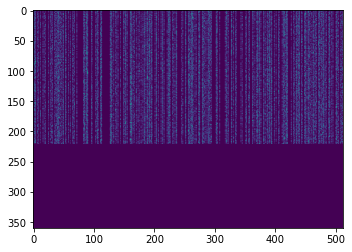

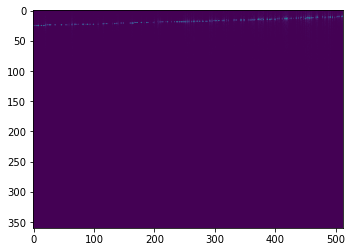

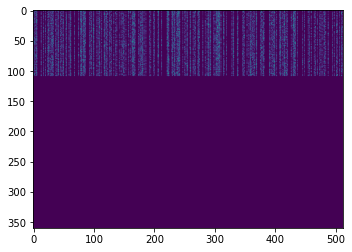

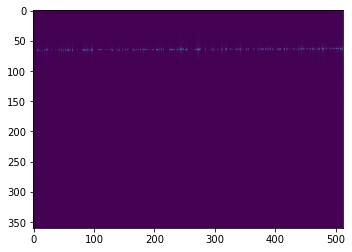

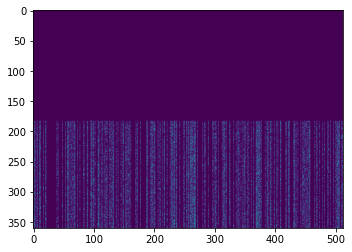

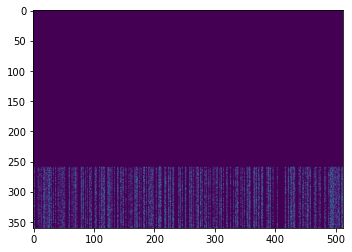

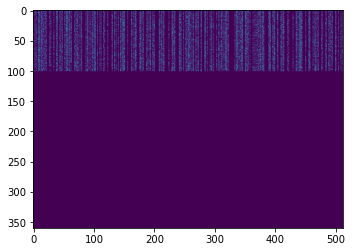

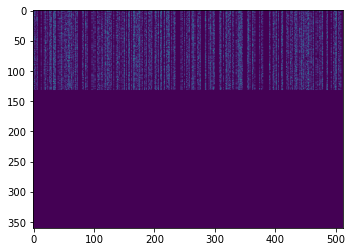

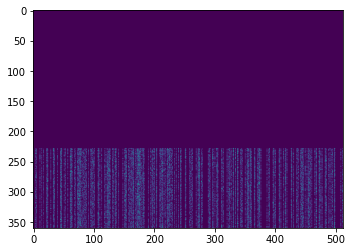

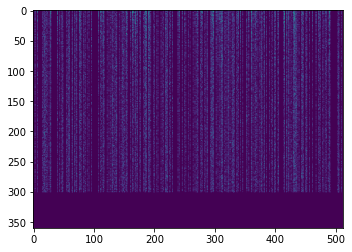

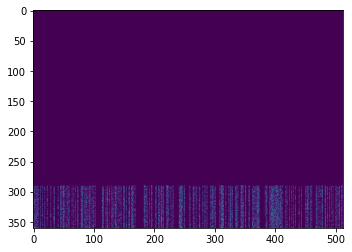

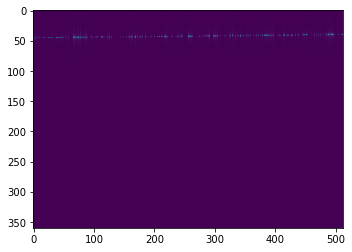

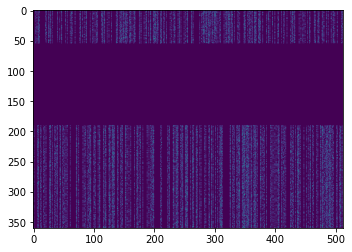

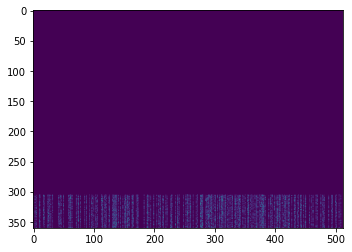

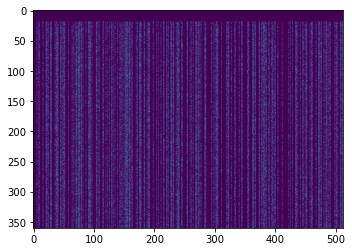

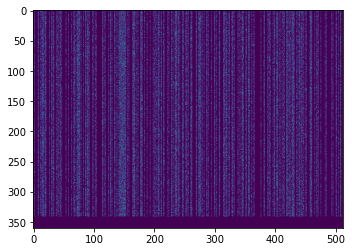

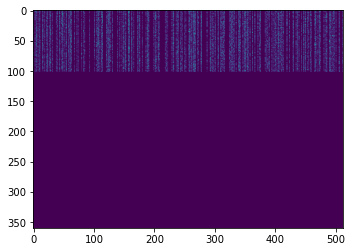

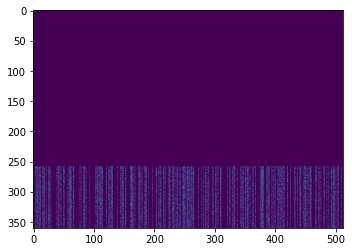

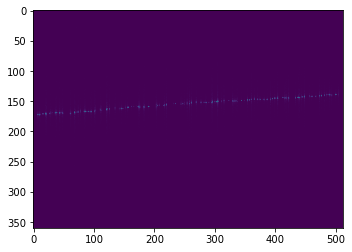

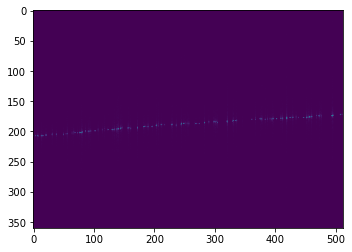

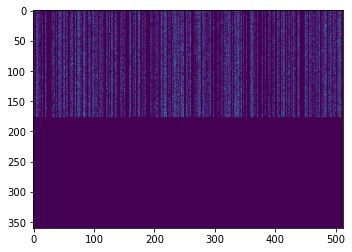

In [66]:
counter = 0
for gid, target in leak_target[['id', 'target']].values:
    if target == 0 and gid in clean_data.keys():
        plt.imshow(clean_data[gid]['H1'][:, :512])
        plt.show()
        plt.close()
        counter += 1
    if counter == 30:
        break

In [71]:
leak_target.sort_values('coverage').tail(20)

,id,target,coverage
31,88b41ef3e,0,0.947222
32,15dacd79b,0,0.947222
154,b530f8500,1,0.972222
155,7cdc4b9ba,0,0.972222
52,a37410a98,0,0.977778
53,214afe4ba,0,0.977778
129,5be5ead6d,0,0.980556
128,8de6e7187,0,0.980556
22,100d44e76,1,0.983333
21,114c6179c,0,0.983333


In [46]:
from configs import *
from configs_chris import *
from kuma_utils.utils import sigmoid

In [65]:
cfg = Ds20l()
model = cfg.model(**cfg.model_params)
checkpoint = torch.load(f'results/{cfg.name}/fold0.pt', 'cpu')
model.load_state_dict(checkpoint['model'])
model.eval()
test = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/test.csv')
test = test.merge(leak_target[['id']], on='id', how='right')

In [68]:
def mask_image(x_tensor, mask_tensor): # (B, C, H, W)
    x_tensor[:, :, mask_tensor, :] = x_tensor.mean()
    return x_tensor


def infer(x_aug0):
    with torch.no_grad():
        x_aug1 = torch.flip(x_aug0, (2,))
        x_aug2 = torch.flip(x_aug0, (3,))
        y_aug0 = model(x_aug0)
        y_aug1 = model(x_aug1)
        y_aug2 = model(x_aug2)
        y = (y_aug0 + y_aug1 + y_aug2) / 3
    return y.item()

In [73]:
dataset = cfg.dataset(
    df=test,
    data_dir=cfg.train_dir,
    transforms=cfg.transforms['test'],
    is_test=True,
    **dict(cfg.dataset_params)
)

In [75]:
updated_target = []
for i, (gid, target) in enumerate(leak_target[['id', 'target']].values):
    if target == 1:
        updated_target.append({'id': gid, 'target': 1})
        continue
    x_mask = mask_image(
        dataset[i][0][None, :, :, :], 
        clean_data[gid]['H1_mask'].sum(1) > 0)
    y_mask = sigmoid(infer(x_mask))
    updated_target.append({'id': gid, 'target': y_mask})
updated_target = pd.DataFrame(updated_target)